In [ ]:
# default_exp classification.data.transforms

In [ ]:
# hide
import warnings

warnings.filterwarnings("ignore")

%load_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
# hide
from nbdev.showdoc import *
from nbdev.export import *
from nbdev.imports import Config as NbdevConfig

nbdev_path = str(NbdevConfig().path("nbs_path") / "data")
nbdev_path

'/Users/ayushman/Desktop/lightning_cv/nbs/data'

<IPython.core.display.Javascript object>

# Transforms for ImageClassification
> Factory methods for creating `Transformations` for a ImageDataset.

This library currently supports transformations from `torchvision`, `timm` & `albumentations`

In [ ]:
# export
import abc
import math
from typing import *

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision.transforms as T

from timm.data.transforms import RandomResizedCropAndInterpolation, _pil_interp
from timm.data.random_erasing import RandomErasing
from timm.data.constants import (
    IMAGENET_DEFAULT_MEAN,
    IMAGENET_DEFAULT_STD,
    DEFAULT_CROP_PCT,
)

from omegaconf import DictConfig
from hydra.utils import instantiate
from fastcore.all import ifnone, basic_repr

from lightning_cv.core import Registry, LOADER_REGISTERY

<IPython.core.display.Javascript object>

In [ ]:
# export
# hide
class ImageNetConstants(NamedTuple):
    MEAN = IMAGENET_DEFAULT_MEAN
    STD = IMAGENET_DEFAULT_STD


class CIFAR10Constants(NamedTuple):
    MEAN = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
    STD = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]

<IPython.core.display.Javascript object>

In [ ]:
# hide
# for tests
from fastcore.all import Path
from omegaconf import OmegaConf
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder

from lightning_cv.config import get_cfg, get_class_path
from lightning_cv.core import LOADER_REGISTERY, download_data, Urls
from lightning_cv.core.utils.common import imshow_tensor, show_images
from lightning_cv.core.utils.data import norm_range

<IPython.core.display.Javascript object>

In [ ]:
# hide
download_data(Urls.DOGS)

Using downloaded and verified file: /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip
Extracting /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip to /Users/ayushman/Desktop/lightning_cv/nbs/data
INFO [03/13 20:28:25 lcv.core.utils.data]: Data downloaded to /Users/ayushman/Desktop/lightning_cv/nbs/data


<IPython.core.display.Javascript object>

In [ ]:
# hide
# export
ClassificationTransformCatalog = Registry("TRANSFORMS")
ClassificationTransformCatalog.__doc__ = (
    "Registery of Transformations Used in Image Classification"
)

<IPython.core.display.Javascript object>

In [ ]:
# export
# hide
class ImageClassificationTransforms(abc.ABC):
    "Class representing a data transform abstraction."
    transforms = None
    __repr__ = basic_repr("transforms")

    @abc.abstractmethod
    def __call__(self, **kwargs):
        """
        The interface `__call__` is used to transform the input data. It should contain
        the actual implementation of data transform. Override this function.
        Args:
            image: input image data
        """
        raise NotImplementedError

    @abc.abstractclassmethod
    def from_config(cls, config: DictConfig):
        "Instantiate a cls from config"
        raise NotImplementedError

<IPython.core.display.Javascript object>

In [ ]:
# export
@ClassificationTransformCatalog.register()
class TorchvisionTransform(ImageClassificationTransforms):
    "Base class for creating torchvision transforms"

    def __init__(self, transforms: List):
        self.transforms = T.Compose(transforms)

    def __call__(self, image):
        return self.transforms(image)

    @classmethod
    def from_config(cls, config: DictConfig):
        "Loads in transformations from a `config`"
        # instantiate transforms using hydra `instantiate`
        transforms = [instantiate(t) for t in config]
        return cls(transforms=transforms)

<IPython.core.display.Javascript object>

In [ ]:
show_doc(TorchvisionTransform)

<h2 id="TorchvisionTransform" class="doc_header"><code>class</code> <code>TorchvisionTransform</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>TorchvisionTransform</code>(**`transforms`**:`List`\[`T`\]) :: [`ImageClassificationTransforms`](/lightning_cv/classification.data.transforms.html#ImageClassificationTransforms)

Base class for creating torchvision transforms

<IPython.core.display.Javascript object>

This class takes in a List of `Torchvision Transforms` and wraps it under `torchvision.transforms.Compose`

In [ ]:
show_doc(TorchvisionTransform.from_config)

<h4 id="TorchvisionTransform.from_config" class="doc_header"><code>TorchvisionTransform.from_config</code><a href="__main__.py#L12" class="source_link" style="float:right">[source]</a></h4>

> <code>TorchvisionTransform.from_config</code>(**`config`**:`DictConfig`)

Loads in transformations from a `config`

<IPython.core.display.Javascript object>

`TorchvisionTransform` can also be instantiated from a `Omegaconf`/ `Hydra` config file. Under the hood we load in the transformations from config using `hydra.utils.instantiate`.

**Example Usage -**

- Create the `Transformations` config 

In [ ]:
cfg = get_cfg(overrides=["transforms=demo"])
# Let's first take a look at the config of transformations
print(OmegaConf.to_yaml(cfg.TRANSFORMS, resolve=True))

TRAIN:
  LOADER: pil_loader
  NAME: TorchvisionTransform
  ARGUMENTS:
  - _target_: torchvision.transforms.RandomResizedCrop
    size:
    - 255
    - 255
  - _target_: torchvision.transforms.ToTensor
  - _target_: torchvision.transforms.Normalize
    mean:
    - 0.485
    - 0.456
    - 0.406
    std:
    - 0.229
    - 0.224
    - 0.225
VALID:
  LOADER: pil_loader
  NAME: TorchvisionTransform
  ARGUMENTS:
  - _target_: torchvision.transforms.Resize
    size:
    - 255
    - 255
  - _target_: torchvision.transforms.ToTensor
  - _target_: torchvision.transforms.Normalize
    mean:
    - 0.485
    - 0.456
    - 0.406
    std:
    - 0.229
    - 0.224
    - 0.225



<IPython.core.display.Javascript object>

> Note: We will go through each of these sections of the `config` at a later section.

* Modify the config file and set your own config

In [ ]:
# collapse-output
# specify the loader; by default torchvision.transforms used pil_loader
cfg.TRANSFORMS.TRAIN.LOADER = "pil_loader"

# torchvision transformations
cfg.TRANSFORMS.TRAIN.ARGUMENTS = [
    dict(
        _target_=get_class_path(T.Resize),
        size=(255, 255),
        interpolation=1,
    ),
    dict(
        _target_=get_class_path(T.ColorJitter),
        brightness=0.4,
        contrast=0.4,
        saturation=0.4,
    ),
    dict(_target_=get_class_path(T.ToTensor)),
    dict(
        _target_=get_class_path(T.Normalize),
        mean=ImageNetConstants.MEAN,
        std=ImageNetConstants.STD,
    ),
]

print(OmegaConf.to_yaml(cfg.TRANSFORMS.TRAIN, resolve=True))

LOADER: pil_loader
NAME: TorchvisionTransform
ARGUMENTS:
- _target_: torchvision.transforms.transforms.Resize
  size:
  - 255
  - 255
  interpolation: 1
- _target_: torchvision.transforms.transforms.ColorJitter
  brightness: 0.4
  contrast: 0.4
  saturation: 0.4
- _target_: torchvision.transforms.transforms.ToTensor
- _target_: torchvision.transforms.transforms.Normalize
  mean:
  - 0.485
  - 0.456
  - 0.406
  std:
  - 0.229
  - 0.224
  - 0.225



<IPython.core.display.Javascript object>

- Create `Dataset' s` and `Dataloader 's` instance

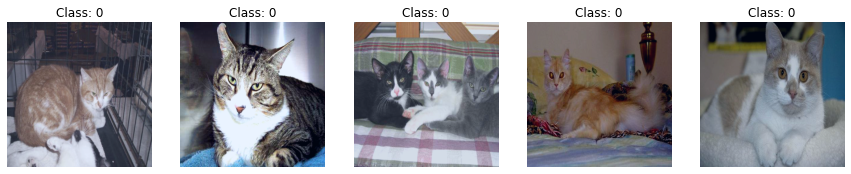

<IPython.core.display.Javascript object>

In [ ]:
# Load in Transformations
tfms = ClassificationTransformCatalog.get(cfg.TRANSFORMS.TRAIN.NAME)
tfms = tfms.from_config(cfg.TRANSFORMS.TRAIN.ARGUMENTS)

# be sure to set the appropriate Loader
# in the case below we are using Torchvision transforms which accepts PIL Images
# so use `pil_loader` from LOADER_REGISTERY
dset = ImageFolder(
    root=f"{nbdev_path}/cats_and_dogs_filtered/train",
    loader=LOADER_REGISTERY.get(cfg.TRANSFORMS.TRAIN.LOADER),
    transform=tfms,
)

dl = torch.utils.data.DataLoader(dset, batch_size=5, shuffle=True)

images, targets = next(iter(dl))

norm_range(images, None)
show_images(images, titles=[f"Class: {i}" for i in targets.data.numpy()])

In [ ]:
# export
@ClassificationTransformCatalog.register()
class AlbumentationsTransform(ImageClassificationTransforms):
    "Base class for creating albumentations transforms"

    def __init__(self, transforms: List):
        self.transforms = A.Compose(transforms)

    def __call__(self, image):
        return self.transforms(image=image)["image"]

    @classmethod
    def from_config(cls, config: DictConfig):
        "Loads in transformations from a `config`"
        transforms = [instantiate(t) for t in config]
        return cls(transforms=transforms)

<IPython.core.display.Javascript object>

Similar to `TorchvisionTransform` but using image-augmentations from `Albumentations`. Note this class requires the images to be loaded in via `cv2` use the utility function `cv2_loader` to load in images.

In [ ]:
# collapse-output
# list of albumentation transformations
tfms = [
    dict(_target_=get_class_path(A.Resize), height=255, width=255, interpolation=2),
    dict(_target_=get_class_path(A.Cutout), p=1.0),
    dict(_target_=get_class_path(A.Normalize), p=1.0),
    dict(_target_=get_class_path(A.pytorch.ToTensorV2), p=1.0),
]


# create config file
cfg = get_cfg()
cfg.TRANSFORMS.TRAIN.NAME = "AlbumentationsTransform"
cfg.TRANSFORMS.TRAIN.LOADER = "cv2_loader"
cfg.TRANSFORMS.TRAIN.ARGUMENTS = OmegaConf.create(tfms)


print(OmegaConf.to_yaml(cfg.TRANSFORMS.TRAIN, resolve=True))

LOADER: cv2_loader
NAME: AlbumentationsTransform
ARGUMENTS:
- _target_: albumentations.augmentations.transforms.Resize
  height: 255
  width: 255
  interpolation: 2
- _target_: albumentations.augmentations.transforms.Cutout
  p: 1.0
- _target_: albumentations.augmentations.transforms.Normalize
  p: 1.0
- _target_: albumentations.pytorch.transforms.ToTensorV2
  p: 1.0



<IPython.core.display.Javascript object>

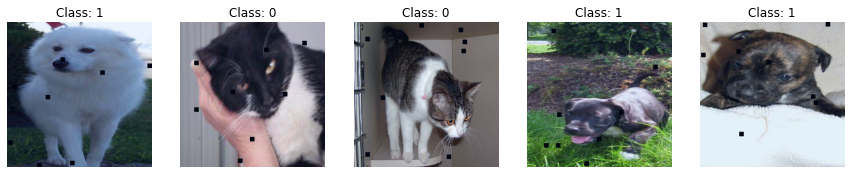

<IPython.core.display.Javascript object>

In [ ]:
# Load in Transformations
tfms = ClassificationTransformCatalog.get(cfg.TRANSFORMS.TRAIN.NAME)
tfms = tfms.from_config(cfg.TRANSFORMS.TRAIN.ARGUMENTS)

dset = ImageFolder(
    root=f"{nbdev_path}/cats_and_dogs_filtered/train",
    loader=LOADER_REGISTERY.get(cfg.TRANSFORMS.TRAIN.LOADER),
    transform=tfms,
)

dl = torch.utils.data.DataLoader(dset, batch_size=5, shuffle=True)

images, targets = next(iter(dl))

# display images
norm_range(images, None)
show_images(images, titles=[f"Class: {i}" for i in targets.data.numpy()])

In [ ]:
# export
# modified from : https://github.com/rwightman/pytorch-image-models/blob/master/timm/data/transforms_factory.py
@ClassificationTransformCatalog.register()
class ImagenetNoAugmentTransform(TorchvisionTransform):
    "The default image transform without data augmentation. This can also be used for validation datasets"

    def __init__(
        self,
        img_size: Union[Tuple, int],
        crop_pct: float = DEFAULT_CROP_PCT,
        interpolation: str = "bilinear",
        mean: Union[Tuple, List] = IMAGENET_DEFAULT_MEAN,
        std: Union[Tuple, List] = IMAGENET_DEFAULT_STD,
    ):

        if isinstance(img_size, tuple):
            assert len(img_size) == 2
            if img_size[-1] == img_size[-2]:
                scale_size = int(math.floor(img_size[0] / crop_pct))
            else:
                scale_size = tuple([int(x / crop_pct) for x in img_size])
        else:
            scale_size = int(math.floor(img_size / crop_pct))

        tfl = [
            T.Resize(scale_size, _pil_interp(interpolation)),
            T.CenterCrop(img_size),
            T.ToTensor(),
            T.Normalize(mean=torch.tensor(mean), std=torch.tensor(std)),
        ]

        self.transforms = T.Compose(tfl)

    @classmethod
    def from_config(cls, config: DictConfig):
        return cls(**config)

<IPython.core.display.Javascript object>

> Note : `ImagenetNoAugmentTransform` uses `pil_loader`

In [ ]:
# collapse-output
tfms = dict(
    img_size=255,
    crop_pct=DEFAULT_CROP_PCT,
    interpolation="bicubic",
    mean=ImageNetConstants.MEAN,
    std=ImageNetConstants.STD,
)

# create config file
cfg = get_cfg()
cfg.TRANSFORMS.TRAIN.NAME = "ImagenetNoAugmentTransform"
cfg.TRANSFORMS.TRAIN.LOADER = "pil_loader"
cfg.TRANSFORMS.TRAIN.ARGUMENTS = OmegaConf.create(tfms)

print(OmegaConf.to_yaml(cfg.TRANSFORMS.TRAIN, resolve=True))

LOADER: pil_loader
NAME: ImagenetNoAugmentTransform
ARGUMENTS:
  img_size: 255
  crop_pct: 0.875
  interpolation: bicubic
  mean:
  - 0.485
  - 0.456
  - 0.406
  std:
  - 0.229
  - 0.224
  - 0.225



<IPython.core.display.Javascript object>

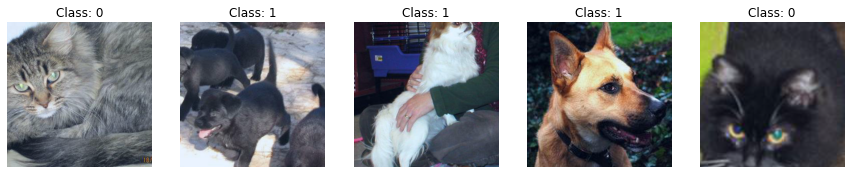

<IPython.core.display.Javascript object>

In [ ]:
# Load in Transformations
tfms = ClassificationTransformCatalog.get(cfg.TRANSFORMS.TRAIN.NAME)
tfms = tfms.from_config(cfg.TRANSFORMS.TRAIN.ARGUMENTS)

dset = ImageFolder(
    root=f"{nbdev_path}/cats_and_dogs_filtered/train",
    loader=LOADER_REGISTERY.get(cfg.TRANSFORMS.TRAIN.LOADER),
    transform=tfms,
)

dl = torch.utils.data.DataLoader(dset, batch_size=5, shuffle=True)

images, targets = next(iter(dl))

# display images
norm_range(images, None)
show_images(images, titles=[f"Class: {i}" for i in targets.data.numpy()])

In [ ]:
# export
# modified from : https://github.com/rwightman/pytorch-image-models/blob/master/timm/data/transforms_factory.py
@ClassificationTransformCatalog.register()
class GenericImageTransform(TorchvisionTransform):
    """
    Default transform for images used in the classification task. This is similar to
    `transforms_imagenet_train` from timm library.
    """

    def __init__(
        self,
        img_size: Union[Tuple, int],
        interpolation: str = "random",
        scale: Optional[Union[List, Tuple]] = None,
        ratio: Optional[Union[List, Tuple]] = None,
        hflip: float = 0.5,
        vflip: float = 0.5,
        color_jitter: Optional[Union[List, Tuple, float]] = 0.4,
        re_prob: float = 0.0,
        re_mode: str = "const",
        re_count: int = 1,
        re_num_splits: int = 0,
        mean: Union[Tuple, List] = IMAGENET_DEFAULT_MEAN,
        std: Union[Tuple, List] = IMAGENET_DEFAULT_STD,
    ):

        # default imagenet scale range
        scale = tuple(ifnone(scale, (0.08, 1.0)))
        # default imagenet ratio range
        ratio = tuple(ifnone(ratio, (3.0 / 4.0, 4.0 / 3.0)))

        tfl = [
            RandomResizedCropAndInterpolation(
                img_size, scale=scale, ratio=ratio, interpolation=interpolation
            )
        ]

        if hflip > 0.0:
            tfl += [T.RandomHorizontalFlip(p=hflip)]

        if vflip > 0.0:
            tfl += [T.RandomVerticalFlip(p=vflip)]

        if color_jitter is not None:
            if isinstance(color_jitter, (list, tuple)):
                assert len(color_jitter) in (3, 4)
            else:
                # if it's a scalar, duplicate for brightness, contrast, and saturation, no hue
                color_jitter = (float(color_jitter),) * 3

            tfl += [T.ColorJitter(*color_jitter)]

        tfl += [T.ToTensor(), T.Normalize(mean, std)]

        if re_prob > 0.0:
            tfl += [
                RandomErasing(
                    re_prob,
                    mode=re_mode,
                    max_count=re_count,
                    num_splits=re_num_splits,
                    device="cpu",
                )
            ]

        # Compose Transformations
        self.transforms = T.Compose(tfl)

    @classmethod
    def from_config(cls, config: DictConfig):
        return cls(**config)

<IPython.core.display.Javascript object>

Transformations used in the above utility class :
1. `RandomResizedCropAndInterpolation`
2. `T.RandomHorizontalFlip` & `T.RandomVerticalFlip`
3. `T.ColorJitter`
4. `T.Normalize, T.ToTensor`
5. `RandomErasing`

> Note: This class doesn't implement `auto-augment` transformations.

In [ ]:
show_doc(GenericImageTransform)

<h2 id="GenericImageTransform" class="doc_header"><code>class</code> <code>GenericImageTransform</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>GenericImageTransform</code>(**`img_size`**:`Union`\[`Tuple`, `int`\], **`interpolation`**:`str`=*`'random'`*, **`scale`**:`Union`\[`List`\[`T`\], `Tuple`, `NoneType`\]=*`None`*, **`ratio`**:`Union`\[`List`\[`T`\], `Tuple`, `NoneType`\]=*`None`*, **`hflip`**:`float`=*`0.5`*, **`vflip`**:`float`=*`0.5`*, **`color_jitter`**:`Union`\[`List`\[`T`\], `Tuple`, `float`, `NoneType`\]=*`0.4`*, **`re_prob`**:`float`=*`0.0`*, **`re_mode`**:`str`=*`'const'`*, **`re_count`**:`int`=*`1`*, **`re_num_splits`**:`int`=*`0`*, **`mean`**:`Union`\[`Tuple`, `List`\[`T`\]\]=*`(0.485, 0.456, 0.406)`*, **`std`**:`Union`\[`Tuple`, `List`\[`T`\]\]=*`(0.229, 0.224, 0.225)`*) :: [`TorchvisionTransform`](/lightning_cv/classification.data.transforms.html#TorchvisionTransform)

Default transform for images used in the classification task. This is similar to
`transforms_imagenet_train` from timm library.

<IPython.core.display.Javascript object>

In [ ]:
# collapse-output
tfms = dict(
    img_size=255,
    interpolation="random",
    scale=None,
    ratio=None,
    hflip=0.5,
    vflip=0.5,
    color_jitter=0.2,
    re_prob=0.5,
    re_mode="pixel",
    mean=ImageNetConstants.MEAN,
    std=ImageNetConstants.STD,
)

# create config file
cfg = get_cfg()
cfg.TRANSFORMS.TRAIN.NAME = "GenericImageTransform"
cfg.TRANSFORMS.TRAIN.LOADER = "pil_loader"
cfg.TRANSFORMS.TRAIN.ARGUMENTS = OmegaConf.create(tfms)

print(OmegaConf.to_yaml(cfg.TRANSFORMS.TRAIN, resolve=True))

LOADER: pil_loader
NAME: GenericImageTransform
ARGUMENTS:
  img_size: 255
  interpolation: random
  scale: null
  ratio: null
  hflip: 0.5
  vflip: 0.5
  color_jitter: 0.2
  re_prob: 0.5
  re_mode: pixel
  mean:
  - 0.485
  - 0.456
  - 0.406
  std:
  - 0.229
  - 0.224
  - 0.225



<IPython.core.display.Javascript object>

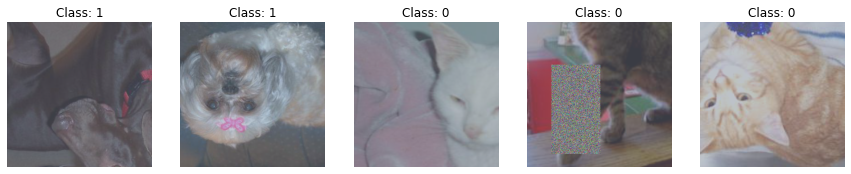

<IPython.core.display.Javascript object>

In [ ]:
# Load in Transformations
tfms = ClassificationTransformCatalog.get(cfg.TRANSFORMS.TRAIN.NAME)
tfms = tfms.from_config(cfg.TRANSFORMS.TRAIN.ARGUMENTS)

dset = ImageFolder(
    root=f"{nbdev_path}/cats_and_dogs_filtered/train",
    loader=LOADER_REGISTERY.get(cfg.TRANSFORMS.TRAIN.LOADER),
    transform=tfms,
)

dl = torch.utils.data.DataLoader(dset, batch_size=5, shuffle=True)

images, targets = next(iter(dl))

# display images
norm_range(images, None)
show_images(images, titles=[f"Class: {i}" for i in targets.data.numpy()])

In [ ]:
# export
# inspired from : https://docs.fast.ai/vision.augment.html#aug_transforms
@ClassificationTransformCatalog.register()
class AugTransforms(AlbumentationsTransform):
    """
    Utility func to easily create a list of flip, affine, lighting, cutout transforms
    using Albumentations Library.

    1. `border_mode` and `interpolation` are OpenCV flag.
    2. `do_flip` and `flip_vert` applies Horizontal/ Vertical flips with a prob of 0.5
    3. `shift_limit`, `scale_limit`, `max_rotate` are parameters for `albumentations.ShiftScaleRotate`
    4. `max_lighting` parameter for `albumentations.HueSaturationValue`
    5. `p_shift`, `p_lighting`, `p_cutout` probablities for `ShiftScaleRotate`, `HueSaturationValue` & `CutOut`.
    """

    def __init__(
        self,
        img_size: Union[int, List, Tuple],
        scale: Optional[Union[List, Tuple]] = None,
        ratio: Optional[Union[List, Tuple]] = None,
        interpolation: int = 1,
        do_flip: bool = True,
        flip_vert: bool = False,
        shift_limit: float = 0.0625,
        scale_limit: float = 0.1,
        max_rotate: float = 45,
        border_mode: int = 4,
        max_lighting: Optional[Union[List, Tuple, float]] = 0.4,
        p_shift: float = 0.5,
        p_lighting: float = 0.75,
        p_cutout: Optional[float] = 0.5,
        mean: Union[Tuple, List] = IMAGENET_DEFAULT_MEAN,
        std: Union[Tuple, List] = IMAGENET_DEFAULT_STD,
    ):

        # default imagenet scale range
        scale = tuple(ifnone(scale, (0.08, 1.0)))
        # default imagenet ratio range
        ratio = tuple(ifnone(ratio, (3.0 / 4.0, 4.0 / 3.0)))
        if isinstance(img_size, list) or isinstance(img_size, tuple):
            tfl = [
                A.RandomResizedCrop(
                    img_size[0], img_size[1], scale, ratio, interpolation, p=1.0
                )
            ]
        else:
            tfl = [
                A.RandomResizedCrop(
                    img_size, img_size, scale, ratio, interpolation, p=1.0
                )
            ]

        if do_flip:
            tfl += [A.HorizontalFlip(p=0.5)]
        if flip_vert:
            tfl += [A.VerticalFlip(p=0.5)]

        tfl += [
            A.ShiftScaleRotate(
                shift_limit,
                scale_limit,
                max_rotate,
                interpolation,
                border_mode,
                p=p_shift,
            )
        ]

        if max_lighting is not None:
            if isinstance(max_lighting, (list, tuple)):
                assert len(max_lighting) in (3, 4)
            else:
                # if it's a scalar, duplicate for brightness, contrast, and saturation, no hue
                max_lighting = (float(max_lighting),) * 3

            tfl += [
                A.HueSaturationValue(*max_lighting, p=p_lighting, always_apply=False)
            ]

        if p_cutout is not None:
            tfl += [A.Cutout(p=p_cutout)]

        tfl += [A.Normalize(mean, std, max_pixel_value=255.0, p=1.0), ToTensorV2(p=0.5)]
        self.transforms = A.Compose(tfl)

    @classmethod
    def from_config(cls, config: DictConfig):
        return cls(**config)

<IPython.core.display.Javascript object>

Arguments to `AugTransforms`:  
* `img_size`: size to which images should be resized.
* `scale`, `ratio`: scale and ration for image resizing. Defaults to imagenet scale and ratio.
* `interpolation` (OpenCV flag): flag that is used to specify the interpolation algorithm.
* `do_flip` (bool): Horizontally flip the images with probability of 0.5.
* `flip_vert` (bool): Vertically flip the images with ptobability of 0.5.
* `shift_limit`: shift factor range for both height and width.
* `scale_limit`: scaling factor range.
* `max_rotate`: rotation range.
* `border_mode` (OpenCV flag): flag that is used to specify the pixel extrapolation method.
* `max_lighting`: Factor to change hue, saturation and value of the input image.
* `p_shift`: Probability for appyling `albumentations.ShiftScaleRotate`.
* `p_lighting`: Probability for appyling `albumentations.HueSaturationValue`.
* `p_cutout`: Probability for applying CutOut to the Images.
* `mean`: Mean for Normalizing the Images.
* `std`: STD for Normalizing the Images.

In [ ]:
# collapse-output
tfms = dict(
    img_size=255,
    do_flip=True,
    flip_vert=True,
    max_lighting=0.2,
    max_rotate=60,
    p_shift=0.5,
    p_lighting=1.0,
    p_cutout=0.5,
)

# create config file
cfg = get_cfg()
cfg.TRANSFORMS.TRAIN.NAME = "AugTransforms"
cfg.TRANSFORMS.TRAIN.LOADER = "cv2_loader"
cfg.TRANSFORMS.TRAIN.ARGUMENTS = OmegaConf.create(tfms)

print(OmegaConf.to_yaml(cfg.TRANSFORMS.TRAIN, resolve=True))

LOADER: cv2_loader
NAME: AugTransforms
ARGUMENTS:
  img_size: 255
  do_flip: true
  flip_vert: true
  max_lighting: 0.2
  max_rotate: 60
  p_shift: 0.5
  p_lighting: 1.0
  p_cutout: 0.5



<IPython.core.display.Javascript object>

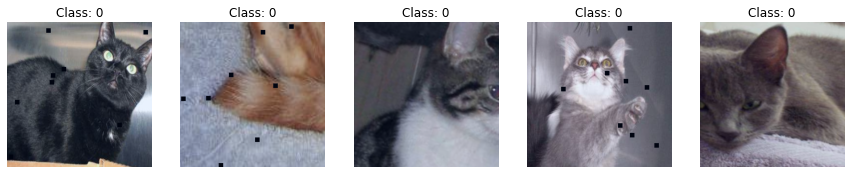

<IPython.core.display.Javascript object>

In [ ]:
# Load in Transformations
tfms = ClassificationTransformCatalog.get(cfg.TRANSFORMS.TRAIN.NAME)
tfms = tfms.from_config(cfg.TRANSFORMS.TRAIN.ARGUMENTS)

dset = ImageFolder(
    root=f"{nbdev_path}/cats_and_dogs_filtered/train",
    loader=LOADER_REGISTERY.get(cfg.TRANSFORMS.TRAIN.LOADER),
    transform=tfms,
)

dl = torch.utils.data.DataLoader(dset, batch_size=5, shuffle=True)

images, targets = next(iter(dl))

# display images
norm_range(images, None)
show_images(images, titles=[f"Class: {i}" for i in targets.data.numpy()])

## Registery  -
> Registery of available Transformations

In [ ]:
show_doc(ClassificationTransformCatalog)

<h4 id="TRANSFORMS" class="doc_header"><code>TRANSFORMS</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Registery of Transformations Used in Image Classification

<IPython.core.display.Javascript object>

In [ ]:
# hide-input
ClassificationTransformCatalog

Registry of TRANSFORMS:
╒════════════════════════════╤═══════════════════════════════════════════════╕
│ Names                      │ Objects                                       │
╞════════════════════════════╪═══════════════════════════════════════════════╡
│ TorchvisionTransform       │ <class '__main__.TorchvisionTransform'>       │
├────────────────────────────┼───────────────────────────────────────────────┤
│ AlbumentationsTransform    │ <class '__main__.AlbumentationsTransform'>    │
├────────────────────────────┼───────────────────────────────────────────────┤
│ ImagenetNoAugmentTransform │ <class '__main__.ImagenetNoAugmentTransform'> │
├────────────────────────────┼───────────────────────────────────────────────┤
│ GenericImageTransform      │ <class '__main__.GenericImageTransform'>      │
├────────────────────────────┼───────────────────────────────────────────────┤
│ AugTransforms              │ <class '__main__.AugTransforms'>              │
╘═══════════════════════════

<IPython.core.display.Javascript object>

You can also create your own `ImageClassificationTransforms` from either `TorchvisionTransform` or `AlbumentationsTransform` and register them to the `ClassificationTransformCatalog`. 

Override `__init__` and `from_config` to set your own transforms. 

> Note: All Transforms must have a `from_config` class method. This class instantiates the class given a `Omegaconf`/`Hydra` config.

In [ ]:
@ClassificationTransformCatalog.register()
class MyRandomTransforms(TorchvisionTransform):
    def __init__(self, sz: Union[Tuple, int]):
        transform_list = [
            RandomResizedCropAndInterpolation(sz, interpolation="random"),
            T.ColorJitter(0.4),
            T.GaussianBlur(kernel_size=3),
            T.ToTensor(),
            T.RandomErasing(p=1.0),
            T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
        ]

        self.transforms = T.Compose(transform_list)

    @classmethod
    def from_config(cls, config: DictConfig):
        return cls(**config)

<IPython.core.display.Javascript object>

> Note: If you are subclassing `TorchvisionTransform` or `AlbumentationsTransform` you do not need to override the `__call__` method for general use casses. But if you are subclassing `ImageClassificationTransforms` you need to specify the `__call__` method.

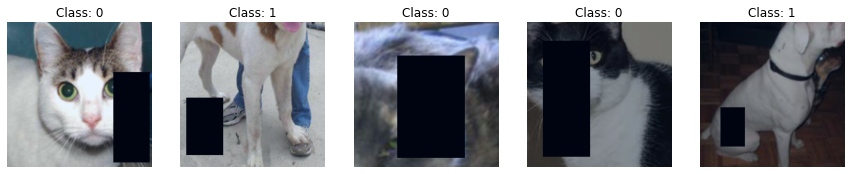

<IPython.core.display.Javascript object>

In [ ]:
# collapse-output
tfms = dict(sz=255)

# create config file
cfg = get_cfg()
cfg.TRANSFORMS.TRAIN.NAME = "MyRandomTransforms"
cfg.TRANSFORMS.TRAIN.LOADER = "pil_loader"
cfg.TRANSFORMS.TRAIN.ARGUMENTS = OmegaConf.create(tfms)


tfms = ClassificationTransformCatalog.get(cfg.TRANSFORMS.TRAIN.NAME)
tfms = tfms.from_config(cfg.TRANSFORMS.TRAIN.ARGUMENTS)

dset = ImageFolder(
    root=f"{nbdev_path}/cats_and_dogs_filtered/train",
    loader=LOADER_REGISTERY.get(cfg.TRANSFORMS.TRAIN.LOADER),
    transform=tfms,
)

dl = torch.utils.data.DataLoader(dset, batch_size=5, shuffle=True)

images, targets = next(iter(dl))

# display images
norm_range(images, None)
show_images(images, titles=[f"Class: {i}" for i in targets.data.numpy()])

## Utility Functions -

In [ ]:
# export
class TransformOutput(NamedTuple):
    "stores the loader and transformations"
    LOADER: Callable = None
    TRANSFORMS: Callable = None

<IPython.core.display.Javascript object>

In [ ]:
# export
def create_transform(cfg: DictConfig) -> Dict[str, TransformOutput]:
    "Utility function to create Image Classification Transformations given `cfg.TRANSFORMS.{TRAIN/VALID}`"

    transform_cls = ClassificationTransformCatalog.get(cfg.NAME)
    transform_cls = transform_cls.from_config(cfg.ARGUMENTS)
    loader = LOADER_REGISTERY.get(cfg.LOADER)

    return TransformOutput(LOADER=loader, TRANSFORMS=transform_cls)

<IPython.core.display.Javascript object>

Let's now look at all the components of `cfg.TRANSFORMS`

In [ ]:
cfg = get_cfg()
print(OmegaConf.to_yaml(cfg.TRANSFORMS))

TRAIN:
  LOADER: pil_loader
  NAME: GenericImageTransform
  ARGUMENTS:
    img_size: 224
    interpolation: random
    hflip: 0.5
    vflip: 0.5
    color_jitter: 0.4
    re_prob: 0.5
    re_mode: pixel
    re_count: 1
    mean:
    - 0.485
    - 0.456
    - 0.406
    std:
    - 0.229
    - 0.224
    - 0.225
VALID:
  LOADER: pil_loader
  NAME: ImagenetNoAugmentTransform
  ARGUMENTS:
    img_size: 224
    interpolation: bilinear
    mean:
    - 0.485
    - 0.456
    - 0.406
    std:
    - 0.229
    - 0.224
    - 0.225



<IPython.core.display.Javascript object>

Here the `TRAIN` and `VALID` key corresponds to transformations for the train & valid dataset. Now the key `NAME` correponds to the name of the `ImageClassificationTransforms` present in `ClassificationTransformCatalog`, and `ARGUMENTS` corresponds to the `parameters` required to instantiate the class. `LOADER` corresponds to the name of the image loader in the `LOADER_REGISTERY` registery.

> Note: Be sure to register all our custom objects in the `ClassificationTransformCatalog` and `LOADER` registery before specify the config with custom objects.

`create_transforms` functions takes in the `cfg` and instantiates the transforms objects like so -

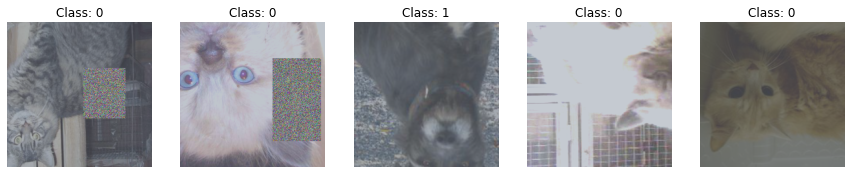

<IPython.core.display.Javascript object>

In [ ]:
tfm_obj = create_transform(cfg.TRANSFORMS.TRAIN)

dset = ImageFolder(
    root=f"{nbdev_path}/cats_and_dogs_filtered/train",
    loader=tfm_obj.LOADER,
    transform=tfm_obj.TRANSFORMS,
)

dl = torch.utils.data.DataLoader(dset, batch_size=5, shuffle=True)

images, targets = next(iter(dl))

# display images
norm_range(images, None)
show_images(images, titles=[f"Class: {i}" for i in targets.data.numpy()])

In [ ]:
# hide
notebook2script()

Converted 00_config.ipynb.
Converted 00a_core.utils.common.ipynb.
Converted 00b_core.utils.data.ipynb.
Converted 00c_core.optim.ipynb.
Converted 00d_core.schedules.ipynb.
Converted 00e_core.layers.ipynb.
Converted 00f_core.losses.py.ipynb.
Converted 01a_classification.data.transforms.ipynb.
Converted 01b_classification.data.datasets.ipynb.
Converted 01c_classification.modelling.backbones.ipynb.
Converted 01d_classification.modelling.classifiers.ipynb.
Converted 01e_classification.modelPL.ipynb.
Converted index.ipynb.


<IPython.core.display.Javascript object>